In [1]:
import torch
import os.path as osp
import pickle
import matplotlib.pyplot as plt
import numpy as np

# import transformers
from transforming.train import run_experiment
from transforming.config_objects import ExperimentCfg, DatasetCfg
from transforming.data import IdxDataset
from transforming.encoder import get_encoder
from transforming.network import Transformer
from transforming import utils


device = "cuda" if torch.cuda.is_available() else "cpu"

# set up autoreloading of shared code
%load_ext autoreload
%autoreload 1
%aimport transforming.train,transforming.config_objects,transforming.data,transforming.encoder,transforming.network
%aimport

KeyboardInterrupt: 

In [2]:
data_dir = "/scratch/ssd004/scratch/jackk/1-billion-word-language-modeling-benchmark-r13output"

exp_config = ExperimentCfg(vec_size=1536,
                        n_layer=12,
                        n_heads=12,
                        lr_max=2e-4,
                        lr_min=1e-7,
                        block_size=1024,
                        batch_size=2,
                        grad_accum_steps=128,
                        train_steps=500, # num macro batches
                        num_eval=300,  # num micro batches
                        dtype="float16",
                        compile=False,
                        zero=True,
                        checkpointing=True,
                        normalizer_type="RMSNorm",
                        rmsnorm_p=0.2,
                        layer_norm_posn="pre",
                        posn_embed_type="relative",
                        posn_embed_learnable=False,
                        flash=False,
                        learnable_unembed=True
                        )
if True:  # if dry run, overwrite config with dry_run config
    exp_config = exp_config.get_dry()

exp_config.ddp = False #local_rank is not None

dset_config = DatasetCfg(dataset_path=data_dir,
                        num_workers=4
                        )

datasets = dict(train=IdxDataset("train.bin", exp_config, dset_config),
                eval=IdxDataset("eval.bin", exp_config, dset_config))


In [68]:
exp_config.vec_size = 1280
exp_config.n_layer = 5
net = Transformer("", exp_config, datasets["train"].cfg).to("cuda:0")
simple_inpt = torch.from_numpy(np.asarray([5, 2])).cuda(0).unsqueeze(0)
simple_outpt = torch.from_numpy(np.asarray([2, 9])).cuda(0).unsqueeze(0)
opt = torch.optim.SGD(net.parameters(), 1e-3)

rank 0 cpu deiece
Num parameters: 227.042899 M
Approximate expected train vram usage: 0.00 GB


In [73]:
loss = net(simple_inpt, simple_outpt)[0]
loss.backward()
print(net.embed.weight.grad)
opt.zero_grad(set_to_none=True)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.0644e-02, -2.9448e-02, -3.0063e-02,  ...,  4.5946e-03,
          3.2697e-02, -8.2970e-05],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')


In [76]:
net.add_activation_checkpointing()
loss = net(simple_inpt, simple_outpt)[0]
loss.backward()
print(net.embed.weight.grad)
opt.zero_grad(set_to_none=True)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.0644e-02, -2.9448e-02, -3.0063e-02,  ...,  4.5946e-03,
          3.2697e-02, -8.2970e-05],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')


In [3]:
net = Transformer("checkpoint/large-multi-gpu-zero-rmsnorm.ckpt", exp_config, datasets["train"].cfg).to("cuda:0")
#net.load_model_state_dict("cuda:0")
net.eval()

rank 0 cpu deiece
Num parameters: 495.932544 M
Approximate expected train vram usage: 5.20 GB


Transformer(
  (embed): Embedding(50304, 1536)
  (posn_embed): Embedding(1024, 1536)
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): CustomNormalizer()
      (mha): MultiHeadAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=False)
        (out): Linear(in_features=1536, out_features=1536, bias=False)
        (attn_dropout): Dropout(p=0, inplace=False)
        (out_dropout): Dropout(p=0, inplace=False)
      )
      (ln2): CustomNormalizer()
      (mlp): MLPBlock(
        (w_1): Linear(in_features=1536, out_features=6144, bias=False)
        (act_func): GELU(approximate='none')
        (w_2): Linear(in_features=6144, out_features=1536, bias=False)
        (dropout): Dropout(p=0, inplace=False)
      )
    )
  )
  (unembed): Linear(in_features=1536, out_features=50304, bias=True)
)

In [5]:
with torch.no_grad():
    batch_idx = 50
    encoder = datasets["train"].encoder
    x_example, y_example = datasets["train"][batch_idx][0].cuda(0).unsqueeze(0), datasets["train"][batch_idx][1].cuda(0).unsqueeze(0)
    print(encoder.decode(x_example.cpu().numpy().squeeze(), split=True)[:20])
    print(encoder.decode(y_example.cpu().numpy().squeeze(), split=True)[:20])

[' ,', ' Analy', 'sts', ' warned', ' that', ' Windows', ' 7', ' could', ' be', ' Microsoft', " '", 's', ' last', ' chance', ' to', ' generate', ' significant', ' revenue', ' from', ' operating']
[' Analy', 'sts', ' warned', ' that', ' Windows', ' 7', ' could', ' be', ' Microsoft', " '", 's', ' last', ' chance', ' to', ' generate', ' significant', ' revenue', ' from', ' operating', ' system']


In [23]:
net.generate(encoder, " Analysts warned that", temperature=0)

' Analysts warned that it \'s an hour , a week , " an ultrasound that firmware , more ultrasound an eternity warned it \'s " an week that the week warned " crs an unabs a woman an opportunityBeautiless Yanukovych .\n<EOS>'

In [6]:
net.train()
ans = net(x_example, y_example)
print(encoder.decode(ans[1][0][:20].argmax(dim=-1).cpu().numpy()))
net.eval()

ederation commonly Lymepacedolesterolcf### victimizedã®é­ eighty commonly wards Illustrated rhythms anticuber delightfulcape Modestange


Transformer(
  (embed): Embedding(50304, 1536)
  (posn_embed): Embedding(1024, 1536)
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): CustomNormalizer()
      (mha): MultiHeadAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=False)
        (out): Linear(in_features=1536, out_features=1536, bias=False)
        (attn_dropout): Dropout(p=0, inplace=False)
        (out_dropout): Dropout(p=0, inplace=False)
      )
      (ln2): CustomNormalizer()
      (mlp): MLPBlock(
        (w_1): Linear(in_features=1536, out_features=6144, bias=False)
        (act_func): GELU(approximate='none')
        (w_2): Linear(in_features=6144, out_features=1536, bias=False)
        (dropout): Dropout(p=0, inplace=False)
      )
    )
  )
  (unembed): Linear(in_features=1536, out_features=50304, bias=True)
)

In [5]:
net.generate(datasets["train"].encoder, prompt="In other news,")

'In other news,000 .\n<EOS>'

In [6]:
net.generate(datasets["train"].encoder, prompt="The people were arrested on suspicion", temperature=0)

'The people were arrested on suspicion of the first-time Masters , to run by the Internet Use gem , adding that casinos botched a new , wherever Favirus , "\n<EOS>'

In [10]:
net.generate(datasets["train"].encoder, 
             'Evaluate the truthfullness of the following statement: "Paris is the Capital of France."\n ')

'Evaluate the truthfullness of the following statement: "Paris is the Capital of France."\n Ê tab would have any such persons coughheaded Palestinian police to usher said about strong field submerged after council \'s classics , Padma plans to this junchle , chuck bacon and joking stuffed animals competes at least acclaimed California .\n<EOS>'

Num parameters: 141.965907 M
Approximate expected train vram usage: 2.00 GB


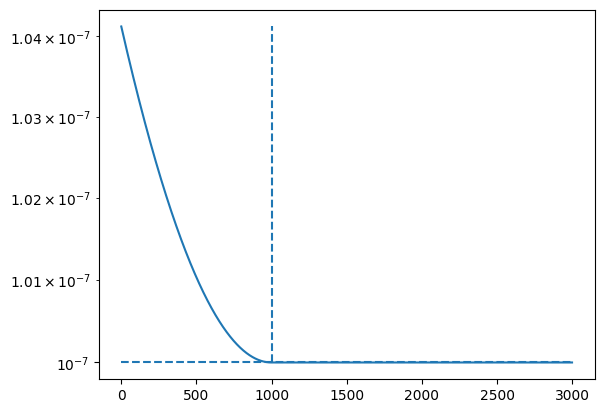

In [25]:
lrs = run_experiment(datasets, "transformer-experiments-google-1-billion", "checkpoints/small-1-gpu.ckpt", exp_config, compile=False)
lrs = lrs[599_000:602_000]
plt.plot(lrs)
plt.gca().set_yscale('log')
#plt.hlines([exp_config.lr_min, exp_config.lr_max], 0,len(lrs), linestyle="--")
plt.hlines([exp_config.lr_min], 0,len(lrs), linestyle="--")
plt.vlines([1_000], exp_config.lr_min, max(lrs), linestyle="--")

In [ ]:
enc = get_encoder()
idx_list = enc.encode("Yo what up, that's so call! Indubitably, albeit that's incomprehensively not watto strengthening my resolve?")
print(idx_list)
print(enc.decode(idx_list))
print(enc.cache)

In [ ]:
eng_files = glob.glob("1-billion-word-language-modeling-benchmark-r13output/training-monolingual.tokenized.shuffled/*")
np.random.shuffle(eng_files)
enc.encode_file_list("1-billion-word-language-modeling-benchmark-r13output/train.bin", eng_files)

eng_files = glob.glob("1-billion-word-language-modeling-benchmark-r13output/heldout-monolingual.tokenized.shuffled/*")
np.random.shuffle(eng_files)
enc.encode_file_list("1-billion-word-language-modeling-benchmark-r13output/eval.bin", eng_files)

In [ ]:
#train_dataset = TextDataset(lines)
data_dir = "1-billion-word-language-modeling-benchmark-r13output"
datasets = dict(train=IdxDataset(osp.join(data_dir, "train")),
                eval=IdxDataset(osp.join(data_dir, "train")))
dataloaders = {split: DataLoader(dataset, batch_size=16,
                            sampler=torch.utils.data.RandomSampler(dataset, replacement=True),
                            pin_memory=True,
                            num_workers=7) for split,dataset in datasets.items()}
print([len(v) for v in dataloaders.values()])
 #   def __init__(self, vocab_size, n_layer, vec_size, n_heads, block_size):

model = Transformer(datasets.vocab_size, n_layer=2, vec_size=120, n_heads=5, block_size=512, save_name="gpt1").to(device)
loss_func = F.cross_entropy()
optim = torch.nn.optim.Adam(model.parameters())
model.load_state_dict(optim=optim)

In [ ]:
train(model, optim, loss_func, 50, dataloaders, device=device)